In [1]:
!pip install qiskit qiskit_aer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.4 MB/s eta 0:00:00


In [2]:
# Grover's Search Algorithm using Qiskit 2.x

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [3]:
def oracle(qc, n, marked_state):
    """Constructs the oracle for the marked state."""
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)  # use mcx() in Qiskit 2.x
    qc.h(n - 1)
    for i, bit in enumerate(marked_state):
        if bit == "0":
            qc.x(i)

In [4]:
def diffuser(qc, n):
    """Implements the Grover diffuser."""
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))

def grover_search(marked_state):
    """Builds Grover's search circuit for a given marked state."""
    n = len(marked_state)
    qc = QuantumCircuit(n, n)
    qc.h(range(n))
    oracle(qc, n, marked_state)
    diffuser(qc, n)
    qc.measure(range(n), range(n))
    return qc

In [5]:
def run_grover(qc):
    """Executes the Grover circuit and displays the result."""
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit, shots=1024).result()
    counts = result.get_counts()
    plot_histogram(counts)
    plt.show()

if __name__ == "__main__":
    marked_state = "101"
    print("Searching for marked state:", marked_state)
    qc = grover_search(marked_state)
    print(qc.draw(fold=-1))
    run_grover(qc)

Searching for marked state: 101
     ┌───┐          ┌───┐┌───┐               ┌───┐┌───┐     ┌─┐      
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────┤M├──────
     ├───┤┌───┐  │  ├───┤├───┤┌───┐       │  ├───┤├───┤     └╥┘┌─┐   
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├───
     ├───┤├───┤┌─┴─┐├───┤├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
c: 3/════════════════════════════════════════════════════════╩══╩══╩═
                                                             0  1  2 


Task 1: Change the marked state

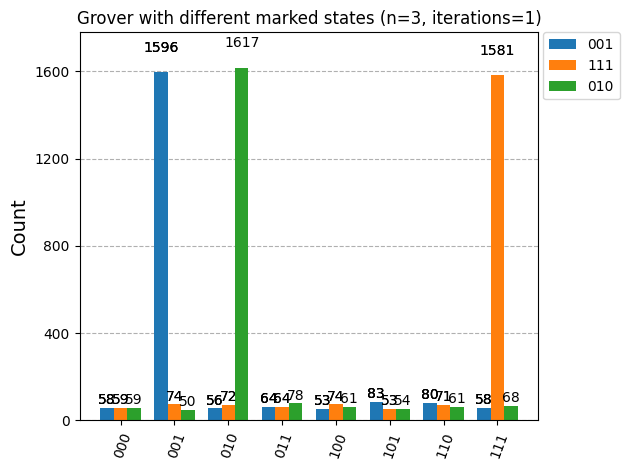

In [9]:
# ===== Task 1: Try different marked states and compare histograms =====
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile
import numpy as np

# Robust, n-agnostic oracle & diffuser (compatible with your notebook signatures)
def oracle(qc, n, marked_state):
    """
    Phase-flip oracle: adds a -1 phase to the |marked_state> basis state.
    Implements: X on '0' bits -> multi-controlled Z -> uncompute X.
    """
    # X on qubits where marked_state bit is '0' (to map |marked_state> to |11..1>)
    for i, b in enumerate(marked_state[::-1]):  # reverse so bit 0 == qubit 0
        if b == '0':
            qc.x(i)

    # Multi-controlled Z using H-CX...-H construction on target qubit
    if n == 1:
        qc.z(0)
    else:
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)  # multi-controlled X
        qc.h(n-1)

    # Uncompute the Xs
    for i, b in enumerate(marked_state[::-1]):
        if b == '0':
            qc.x(i)

def diffuser(qc, n):
    """
    Standard Grover diffuser: reflection about |s>.
    """
    # H, X on all
    for i in range(n):
        qc.h(i); qc.x(i)
    # Multi-controlled Z
    if n == 1:
        qc.z(0)
    else:
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)
        qc.h(n-1)
    # X, H on all
    for i in range(n):
        qc.x(i); qc.h(i)

def run_grover(n, marked_state, iterations=1, shots=2048):
    qc = QuantumCircuit(n, n)
    # Uniform superposition
    for q in range(n):
        qc.h(q)
    # Grover iterations
    for _ in range(iterations):
        oracle(qc, n, marked_state)
        diffuser(qc, n)
    # Measure
    qc.measure(range(n), range(n))
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()
    return counts

# Try multiple marked states; use 1 Grover iteration by default for n=3
n = 3
test_states = ["001", "111", "010"]
iters = 1  # for n=3, 1 iteration is typical
counts_list = {}
for s in test_states:
    counts_list[s] = run_grover(n, s, iterations=iters)

# Plot together
plot_histogram([counts_list[s] for s in test_states], legend=test_states, title=f"Grover with different marked states (n={n}, iterations={iters})")


Task 2: Modify the number of qubits

{'0110': 10, '1000': 8, '1011': 3932, '0111': 6, '0011': 15, '0010': 12, '0000': 7, '0001': 14, '1111': 13, '1010': 14, '1100': 10, '0101': 4, '1001': 12, '1101': 13, '0100': 14, '1110': 12}


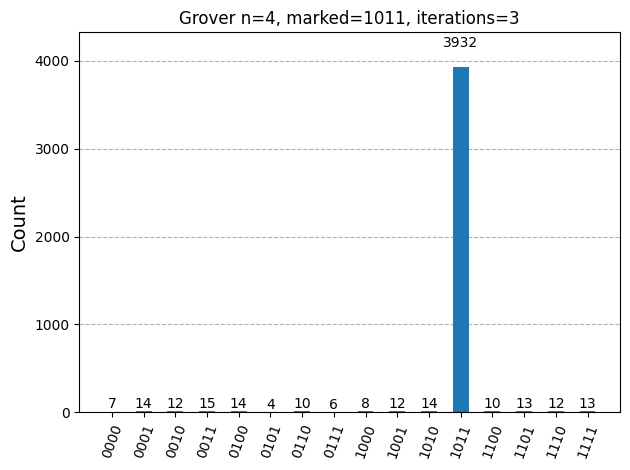

In [10]:
# ===== Task 2: Extend to 4 qubits =====
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile
import numpy as np

# Reuse/confirm robust oracle & diffuser from Task 1 (kept identical)
def oracle(qc, n, marked_state):
    for i, b in enumerate(marked_state[::-1]):
        if b == '0':
            qc.x(i)
    if n == 1:
        qc.z(0)
    else:
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)
        qc.h(n-1)
    for i, b in enumerate(marked_state[::-1]):
        if b == '0':
            qc.x(i)

def diffuser(qc, n):
    for i in range(n):
        qc.h(i); qc.x(i)
    if n == 1:
        qc.z(0)
    else:
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)
        qc.h(n-1)
    for i in range(n):
        qc.x(i); qc.h(i)

def run_grover(n, marked_state, iterations=1, shots=4096):
    qc = QuantumCircuit(n, n)
    for q in range(n):
        qc.h(q)
    for _ in range(iterations):
        oracle(qc, n, marked_state)
        diffuser(qc, n)
    qc.measure(range(n), range(n))
    sim = AerSimulator()
    result = sim.run(transpile(qc, sim), shots=shots).result()
    return result.get_counts(), qc

# 4 qubits: choose any 4-bit marked state
n = 4
marked_state = "1011"  # change freely, must be length 4
# Recommended iterations ≈ floor(pi/4 * sqrt(2^n)) -> for n=4 it's 3
iters = 3

counts_4, qc_4 = run_grover(n, marked_state, iterations=iters)
print(counts_4)
plot_histogram(counts_4, title=f"Grover n=4, marked={marked_state}, iterations={iters}")


Task 3: Add multiple iterations

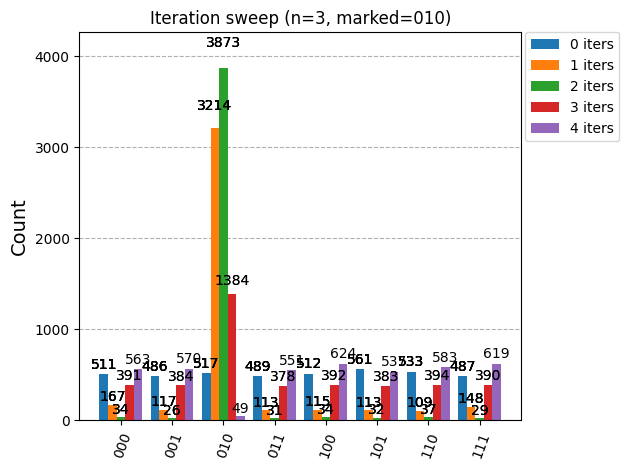

In [18]:
# ===== Task 3: Sweep number of Grover iterations =====
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from collections import OrderedDict
import numpy as np

def run_grover_once(n, marked_state, iterations, shots=4096):
    qc = QuantumCircuit(n, n)
    for q in range(n):
        qc.h(q)
    for _ in range(iterations):
        oracle(qc, n, marked_state)
        diffuser(qc, n)
    qc.measure(range(n), range(n))
    sim = AerSimulator()
    res = sim.run(transpile(qc, sim), shots=shots).result()
    return res.get_counts() # Use .get_counts() to get the dictionary

n = 3
marked_state = "010"
# Try different iteration counts
iters_list = [0, 1, 2, 3, 4]
curves = OrderedDict()
for k in iters_list:
    counts = run_grover_once(n, marked_state, iterations=k)
    curves[f"{k} iters"] = dict(counts) # Convert Counts object to a standard dictionary

# Prepare data for plotting as a list of dictionaries
plot_data = list(curves.values())
legend_labels = list(curves.keys())

plot_histogram(plot_data, legend=legend_labels, title=f"Iteration sweep (n={n}, marked={marked_state})")

Task 4: Circuit Visualization

In [28]:
# ===== Task 4: Visualize the Grover circuit =====
import matplotlib.pyplot as plt

n = 3
marked_state = "111"
iterations = 2

qc = QuantumCircuit(n, n)
# Superposition
for q in range(n):
    qc.h(q)
# Grover iterations
for _ in range(iterations):
    oracle(qc, n, marked_state)
    diffuser(qc, n)
# (Optionally) measure at the end if you want it in the diagram
qc.measure(range(n), range(n))

# Draw using Matplotlib backend (shows in notebook)
qc.draw()


┌───┐          ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐»
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤»
q_1: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤»
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐               ┌───┐┌───┐     ┌─┐      
«q_0: ┤ X ├────────────■──┤ X ├┤ H ├─────┤M├──────
«     ├───┤            │  ├───┤├───┤     └╥┘┌─┐   
«q_1: ┤ X ├────────────■──┤ X ├┤ H ├──────╫─┤M├───
«     ├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
«q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
«c: 3/════════════════════════════════════╩══╩══╩═
«                                         0  1  2

Task 5: Experiment with Noise

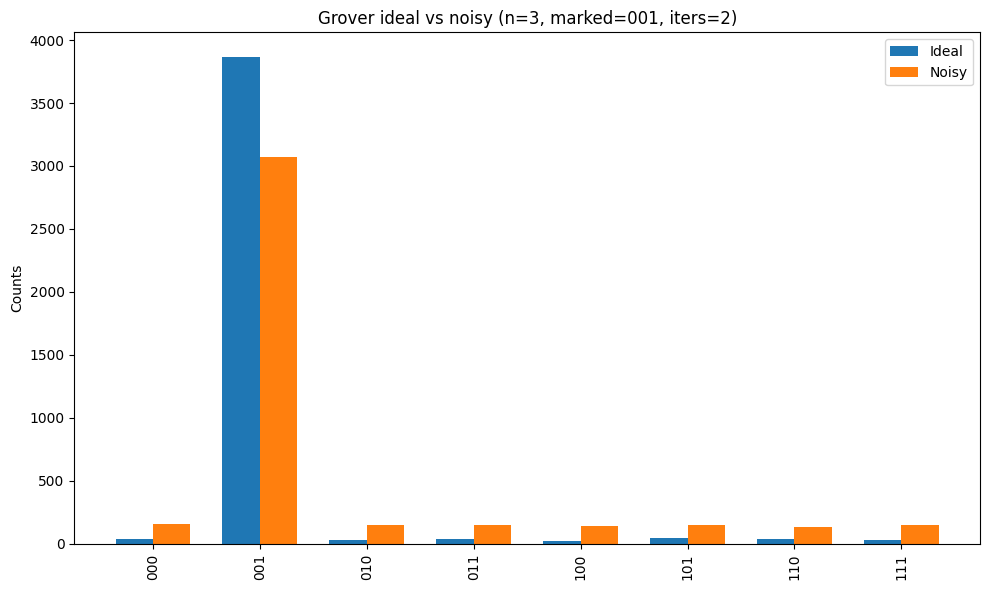

In [32]:
# ===== Task 5: Compare ideal vs noisy simulator =====
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram # Keep import in case it works for other cases
from qiskit import transpile
from qiskit import QuantumCircuit # Import QuantumCircuit
import matplotlib.pyplot as plt # Import Matplotlib

def build_grover_circuit(n, marked_state, iterations):
    qc = QuantumCircuit(n, n)
    for q in range(n):
        qc.h(q)
    for _ in range(iterations):
        oracle(qc, n, marked_state)
        diffuser(qc, n)
    qc.measure(range(n), range(n))
    return qc

# Problem setup
n = 3
marked_state = "001"
iterations = 2
shots = 4096

qc = build_grover_circuit(n, marked_state, iterations)

# --- Ideal run ---
ideal_backend = AerSimulator()
ideal_result = ideal_backend.run(transpile(qc, ideal_backend), shots=shots).result()
ideal_counts = dict(ideal_result.get_counts()) # Explicitly convert to dict

# --- Noisy run: simple depolarizing noise model (tune probabilities as you like) ---
noise_model = NoiseModel()
p1 = 0.002   # 1-qubit depolarizing prob
p2 = 0.01    # 2-qubit depolarizing prob

# Map to typical basis gates in Aer (u, cx) — works broadly
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['u', 'rz', 'sx', 'x', 'h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])

noisy_backend = AerSimulator(noise_model=noise_model)
noisy_result = noisy_backend.run(transpile(qc, noisy_backend), shots=shots).result()
noisy_counts = dict(noisy_result.get_counts()) # Explicitly convert to dict

# Compare using Matplotlib
labels = sorted(list(set(ideal_counts.keys()) | set(noisy_counts.keys())))
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

ideal_values = [ideal_counts.get(label, 0) for label in labels]
noisy_values = [noisy_counts.get(label, 0) for label in labels]

rects1 = ax.bar(x - width/2, ideal_values, width, label='Ideal')
rects2 = ax.bar(x + width/2, noisy_values, width, label='Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title(f"Grover ideal vs noisy (n={n}, marked={marked_state}, iters={iterations})")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

fig.tight_layout()

plt.show()